<a href="https://colab.research.google.com/github/DongheeKang/MachineLearning/blob/master/Transformer_Attention_mechanism_in_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Attention is All You Need (NIPS 2017)
* NLP 
* PyTorch
* GPU in colab


In [1]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.6 MB/s 
     |████████████████████████████████| 1.2 MB 8.1 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.0
    Uninstalling torchtext-0.13.0:
      Successfully uninstalled torchtext-0.13.0


#### Preprocessing

* spaCy: tokenization, tagging for tanslation between english and german

In [2]:
%%capture
!python -m spacy download en
!python -m spacy download de

In [5]:
import spacy

spacy_en = spacy.blank('en') # tokenization
spacy_de = spacy.blank('de') # okenization

In [6]:
tokenized = spacy_en.tokenizer("I am a graduate student.")

for i, token in enumerate(tokenized):
    print(f"index {i}: {token.text}")

index 0: I
index 1: am
index 2: a
index 3: graduate
index 4: student
index 5: .


In [7]:
# Deutsch
def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

# English
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

* use field library
* batch_first = True
* Goal
    * source: DE
    * target: EN

In [8]:
from torchtext.data import Field, BucketIterator

SRC = Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)
TRG = Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)

# Dataset 
* Multi30k

In [9]:
from torchtext.datasets import Multi30k

train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts=(".de", ".en"), fields=(SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 870kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 247kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 240kB/s]


In [10]:
print(f"training dataset: {len(train_dataset.examples)}")
print(f"validation dataset: {len(valid_dataset.examples)}")
print(f"testing dataset: {len(test_dataset.examples)}")

training dataset: 29000
validation dataset: 1014
testing dataset: 1000


In [11]:
print(vars(train_dataset.examples[30])['src'])
print(vars(train_dataset.examples[30])['trg'])

['ein', 'mann', ',', 'der', 'mit', 'einer', 'tasse', 'kaffee', 'an', 'einem', 'urinal', 'steht', '.']
['a', 'man', 'standing', 'at', 'a', 'urinal', 'with', 'a', 'coffee', 'cup', '.']


In [12]:
# appeared two times at least
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 7853
len(TRG): 5893


In [13]:
print(TRG.vocab.stoi["abcabc"]) # not existing word = 0
print(TRG.vocab.stoi[TRG.pad_token]) # padding =  1
print(TRG.vocab.stoi["<sos>"]) # <sos> = 2
print(TRG.vocab.stoi["<eos>"]) # <eos> = 3
print(TRG.vocab.stoi["hello"]) # hello
print(TRG.vocab.stoi["world"]) # world

0
1
2
3
4112
1752


* 한 문장에 포함된 단어가 순서대로 나열된 상태로 네트워크에 입력되어야 합니다.
    * 따라서 하나의 배치에 포함된 문장들이 가지는 단어의 개수가 유사하도록 만들면 좋습니다.
    * 이를 위해 BucketIterator를 사용합니다.
    * **배치 크기(batch size)**: 128

In [14]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

# data loader iterator
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device)

In [15]:
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg

    print(f"size of first batch: {src.shape}")

    for i in range(src.shape[1]):
        print(f"index {i}: {src[0][i].item()}") # [Seq_num, Seq_len]

    # only first batch
    break

size of first batch: torch.Size([128, 41])
index 0: 2
index 1: 5
index 2: 13
index 3: 29
index 4: 10
index 5: 95
index 6: 7
index 7: 17
index 8: 481
index 9: 9
index 10: 35
index 11: 17
index 12: 465
index 13: 98
index 14: 6
index 15: 0
index 16: 0
index 17: 4
index 18: 3
index 19: 1
index 20: 1
index 21: 1
index 22: 1
index 23: 1
index 24: 1
index 25: 1
index 26: 1
index 27: 1
index 28: 1
index 29: 1
index 30: 1
index 31: 1
index 32: 1
index 33: 1
index 34: 1
index 35: 1
index 36: 1
index 37: 1
index 38: 1
index 39: 1
index 40: 1


#### **Multi Head Attention Architecture**

* attention has three parameters
    * queries
    * keys
    * values
    * Query, Key, Value has same dimension
* hyperparameter
    * **hidden_dim**: embeding dimesion for one word
    * **n_heads**: number of head = number of scaled dot-product attention
    * **dropout_ratio**: ratio of dropout

In [16]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원
        self.n_heads = n_heads # 헤드(head)의 개수: 서로 다른 어텐션(attention) 컨셉의 수
        self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원

        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        # query: [batch_size, query_len, hidden_dim]
        # key: [batch_size, key_len, hidden_dim]
        # value: [batch_size, value_len, hidden_dim]
 
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len, hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # hidden_dim → n_heads X head_dim
        # train n_heads(h)'s attentions 
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len, head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # Attention Energy 계산
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy: [batch_size, n_heads, query_len, key_len]

        # when the mast is used...
        if mask is not None:
            # set -1e10 for mask = 0 
            energy = energy.masked_fill(mask==0, -1e10)

        # attentions score for each word
        attention = torch.softmax(energy, dim=-1)

        # attention: [batch_size, n_heads, query_len, key_len]

        # Scaled Dot-Product Attention
        x = torch.matmul(self.dropout(attention), V)

        # x: [batch_size, n_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x: [batch_size, query_len, n_heads, head_dim]

        x = x.view(batch_size, -1, self.hidden_dim)

        # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)

        # x: [batch_size, query_len, hidden_dim]

        return x, attention

#### **Position-wise Feedforward Architecture**

* Input and output dimensions are same

* hyperparameter
    * **hidden_dim**: embeding dimesion for word
    * **pf_dim**: embeding dimesion in Feedforward 
    * **dropout_ratio**: ratio of dropout

In [17]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x

#### **Encoder Layer Architecture**

* Define 
    * input and output same dimension.
    * encoder can be used many times. 
* hyperparameter)
    * **hidden_dim**: embeding dimesion for word
    * **n_heads**: number of scaled dot-product attention
    * **pf_dim**: embeding dimesion in Feedforward 
    * **dropout_ratio**: ratio of dropout

In [18]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # Query, Key, Value
    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

#### **Encoder Architecture**

* hyperparameter
    * **input_dim**: one-hot encoding for input word 
    * **hidden_dim**: embeding dimesion for word
    * **n_layers**: total number of layers
    * **n_heads**: number of scaled dot-product attention
    * **pf_dim**: embeding dimesion in Feedforward
    * **dropout_ratio**: ratio of dropout
    * **max_length**: maximum length of word in a sentence


* use positional embedding during the training
    * BERT uses also positional embedding. 
* set mask = 0.

In [19]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        # add embedding for a source sentence and poistion embeding 
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # perform forward
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src # last layer

#### **Decoder Architecture**

* Define 
    * input and output same dimension.
    * decoder can be used many times. 
    * Two Multi-Head Attentions.

* hyperparameter
    * **hidden_dim**: embeding dimesion for word
    * **n_heads**: number of scaled dot-product attention
    * **pf_dim**: embeding dimesion in Feedforward 
    * **dropout_ratio**: ratio of dropout*
    
* For target sentence, training of each word does not know about next word 

In [20]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # do enc_src to attention
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        # attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # Query attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

#### **Decoder Architecture**


* hyperparameter
    * **input_dim**: one-hot encoding for input word 
    * **hidden_dim**: embeding dimesion for word
    * **n_layers**: total number of layers
    * **n_heads**: number of scaled dot-product attention
    * **pf_dim**: embeding dimesion in Feedforward
    * **dropout_ratio**: ratio of dropout
    * **max_length**: maximum length of word in a sentence


* use positional embedding during the training
    * BERT uses also positional embedding. 
* set mask = 0
* many decoder layers in inference. 
* For target sentence, training of each word does not know about next word 

In [24]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # use mask for source and target
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

#### **Transformer Architecture**


In [21]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # set mask to 0 for <pad> token
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # only previous word can be available, not possible to see next word by masking
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ masking....
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ masking....
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

## Training



In [22]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [25]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# declarartion encoder and decoder
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

* **Initialize weighing parameters**

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


In [27]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7853, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
 

## Define Validation function


In [28]:
import torch.optim as optim

# Adam optimizer
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Cross entropy
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [32]:
# train
def train(model, iterator, optimizer, criterion, clip):
    model.train() 
    epoch_loss = 0

    # for all training
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # ignore last index <eos> from output word 
        # start with <sos>
        output, _ = model(src, trg[:,:-1])

        # output: [total_batch, trg_len - 1, output_dim]
        # trg: [total_batch, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # ignore output word index 0(<sos>)
        trg = trg[:,1:].contiguous().view(-1)

        # output: [total_batch * trg_len - 1, output_dim]
        # trg: [total_batch * trg len - 1]

        # loss and gradient...
        loss = criterion(output, trg)
        loss.backward() # gradient

        # gradient clipping 
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update
        optimizer.step()

        # total loss in a epoch
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [33]:
# evaluate
def evaluate(model, iterator, criterion):
    model.eval() 
    epoch_loss = 0

    with torch.no_grad():
  
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

## training and validation
    * **epoch**: 10

In [34]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [35]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() 

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() 
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 0m 21s
	Train Loss: 4.258 | Train PPL: 70.654
	Validation Loss: 3.062 | Validation PPL: 21.379
Epoch: 02 | Time: 0m 17s
	Train Loss: 2.837 | Train PPL: 17.068
	Validation Loss: 2.325 | Validation PPL: 10.224
Epoch: 03 | Time: 0m 18s
	Train Loss: 2.249 | Train PPL: 9.477
	Validation Loss: 1.986 | Validation PPL: 7.289
Epoch: 04 | Time: 0m 17s
	Train Loss: 1.896 | Train PPL: 6.662
	Validation Loss: 1.812 | Validation PPL: 6.124
Epoch: 05 | Time: 0m 17s
	Train Loss: 1.647 | Train PPL: 5.190
	Validation Loss: 1.717 | Validation PPL: 5.567
Epoch: 06 | Time: 0m 17s
	Train Loss: 1.460 | Train PPL: 4.305
	Validation Loss: 1.661 | Validation PPL: 5.265
Epoch: 07 | Time: 0m 17s
	Train Loss: 1.307 | Train PPL: 3.697
	Validation Loss: 1.621 | Validation PPL: 5.058
Epoch: 08 | Time: 0m 19s
	Train Loss: 1.180 | Train PPL: 3.253
	Validation Loss: 1.620 | Validation PPL: 5.054
Epoch: 09 | Time: 0m 19s
	Train Loss: 1.071 | Train PPL: 2.920
	Validation Loss: 1.627 | Validation PPL: 5.0

In [36]:
# save trained model
from google.colab import files

files.download('transformer_german_to_english.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


## Model testing by reloading trained model

In [37]:
model.load_state_dict(torch.load('transformer_german_to_english.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 1.681 | Test PPL: 5.372


## test of Model

* using test dataset 

In [38]:
# translation 
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True):
    model.eval()  # evaluation!

    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    if logging:
        print(f"source: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"index of source: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # mask 
    src_mask = model.make_src_mask(src_tensor)

    # endocer
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # <sos> token at first
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # mask
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 

        # end when <eos> is appeared
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # convert vocabulrary
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # output
    return trg_tokens[1:], attention

In [39]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'source sentence: {src}')
print(f'target sentence: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("Model output:", " ".join(translation))

source sentence: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
target sentence: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
source: ['<sos>', 'eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.', '<eos>']
index of source: [2, 8, 364, 10, 134, 70, 624, 565, 19, 780, 200, 20, 88, 4, 3]
Model output: a mother and her son enjoying a beautiful day outdoors on the beautiful day . <eos>


## Visulaization of Attention Map

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(15, 25))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # Attentionscore
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [41]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'source: {src}')
print(f'target: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("output:", " ".join(translation))

source: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
target: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
source: ['<sos>', 'eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.', '<eos>']
index of source: [2, 8, 364, 10, 134, 70, 624, 565, 19, 780, 200, 20, 88, 4, 3]
output: a mother and her son enjoying a beautiful day outdoors on the beautiful day . <eos>


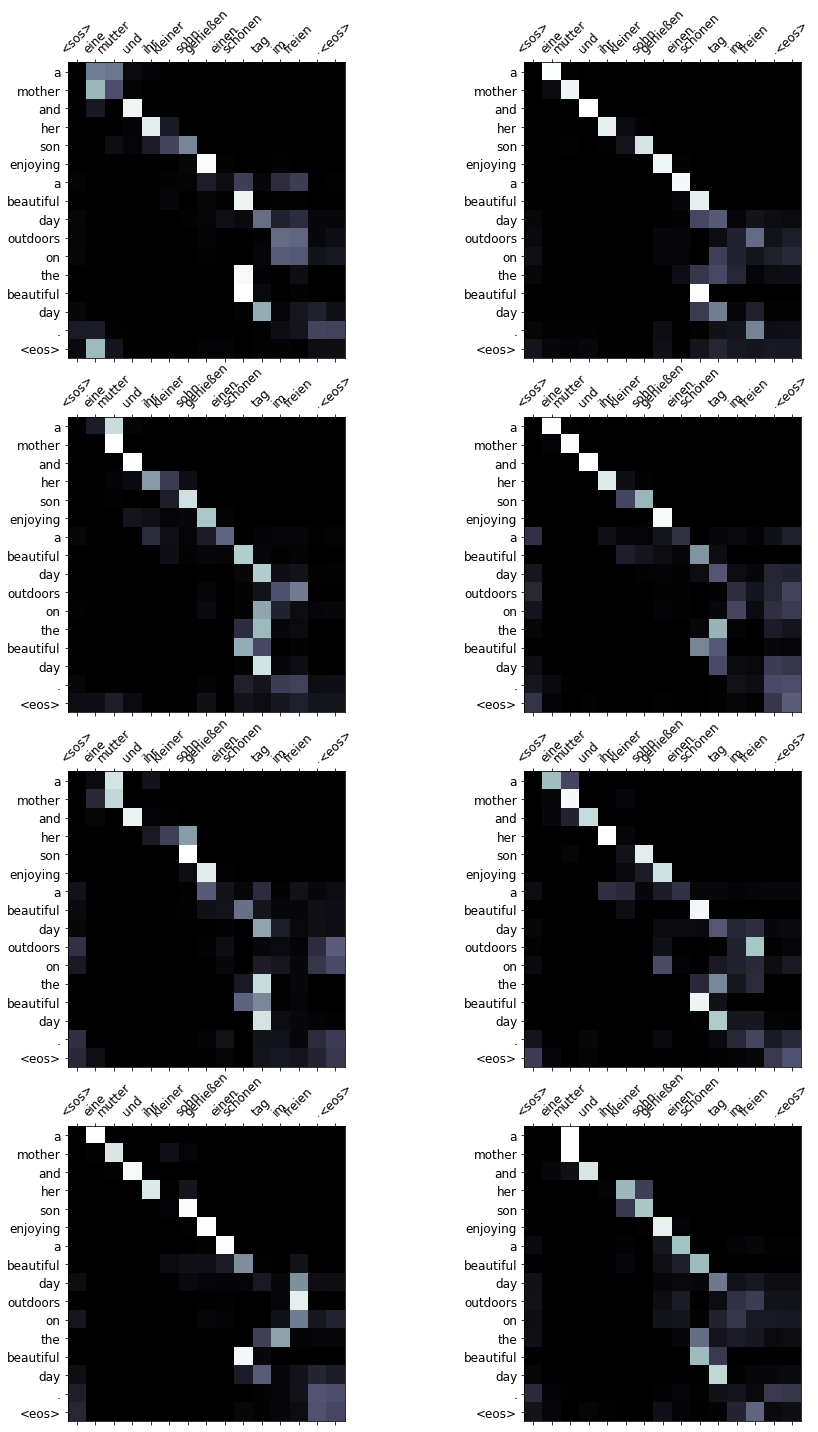

In [42]:
display_attention(src, translation, attention)

## <b>BLEU Score</b>

* Bleu score for Trained ransformer Model

In [43]:
from torchtext.data.metrics import bleu_score

def show_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len, logging=False)

        # ignore last <eos>
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"predict: {pred_trg}")
            print(f"answer: {trg}")

    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')

    individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    print(f'Individual BLEU1 score = {individual_bleu1_score*100:.2f}') 
    print(f'Individual BLEU2 score = {individual_bleu2_score*100:.2f}') 
    print(f'Individual BLEU3 score = {individual_bleu3_score*100:.2f}') 
    print(f'Individual BLEU4 score = {individual_bleu4_score*100:.2f}') 

    cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}') 
    print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}') 
    print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}') 
    print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}') 

In [44]:
show_bleu(test_dataset, SRC, TRG, model, device)

[100/1000]
predict: ['a', 'group', 'of', 'asian', 'children', 'are', 'sitting', 'in', 'blue', 'chairs', 'laid', 'out', 'on', 'blue', 'chairs', '.']
answer: ['a', 'group', 'of', 'mostly', 'asian', 'children', 'sitting', 'at', 'cubicles', 'in', 'blue', 'chairs', '.']
[200/1000]
predict: ['all', 'people', 'all', 'the', 'group', 'of', 'people', 'standing', 'under', 'umbrellas', '.']
answer: ['the', 'group', 'of', 'people', 'are', 'all', 'covered', 'by', 'umbrellas', '.']
[300/1000]
predict: ['a', 'goalie', 'in', 'a', 'yellow', 'jersey', 'is', 'checking', 'the', 'goal', '.']
answer: ['a', 'goalie', 'in', 'a', 'yellow', 'field', 'is', 'protecting', 'the', 'goal', '.']
[400/1000]
predict: ['two', 'young', 'children', 'on', 'the', 'sand', '.']
answer: ['two', 'young', 'children', 'are', 'on', 'sand', '.']
[500/1000]
predict: ['two', 'medium', '-', 'sized', 'dogs', 'are', 'running', 'across', 'the', 'snow', '.']
answer: ['two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.']
[60